I recently found myself switching my DSLR camera system from Canon to Nikon for reasons of marital harmony. That meant ebaying all my four existing Canon lens and replacing them with Nikons. The question was then which Nikon lenses made the most sense to purchase. To make an optimal decision I'd need to know how I'm using my current equipment, so I wrote some python to extract the metadata from all the images I have and run some analysis.

In [1]:
from PIL import Image
import PIL
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Import the metadata parsing script I wrote (script HERE LINK).

In [4]:
import exif_data

In [6]:
df = exif_data.make_df('/Users/frank/Pictures/Photos Library.photoslibrary/Masters',
                       columns=['DateTimeOriginal', 'FocalLength', 'Make', 'Model'])
df.head()

,DateTimeOriginal,FocalLength,Make,Model
0,2015:03:20 15:26:48,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
1,2015:03:20 15:39:40,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
2,2015:03:20 15:39:55,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
3,2015:03:20 15:40:26,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
4,2015:03:20 15:40:42,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi


The operation to get the data is slow (lots of disk I/O), so I made a copy to avoid accidently modifying the original during interactive analysis.

In [7]:
exif_df = df.copy()
exif_df['RealFocalLength'] = exif_df['FocalLength'].apply(
    lambda x: x[0] / float(x[1]) if x is not None else None
)
exif_df.tail()

,DateTimeOriginal,FocalLength,Make,Model,RealFocalLength
11265,2015:07:01 15:07:56,"(180, 10)",NIKON CORPORATION,NIKON D5500,18
11266,2015:07:02 12:44:32,"(520, 10)",NIKON CORPORATION,NIKON D5500,52
11267,2015:07:02 12:44:33,"(520, 10)",NIKON CORPORATION,NIKON D5500,52
11268,None,None,None,None,NaN
11269,None,None,None,None,NaN


Here I investigate statistics broken down by camera, plotting # of photos the cumulative distribution function by focal length. It's clear that on my 8 year old Canon XTi over 80% were taken at focal lengths shorter than 55 mm, which indicated to me that Nikon's extremely light 18-55mm lens would be a better choice than the heavier 18-140mm.

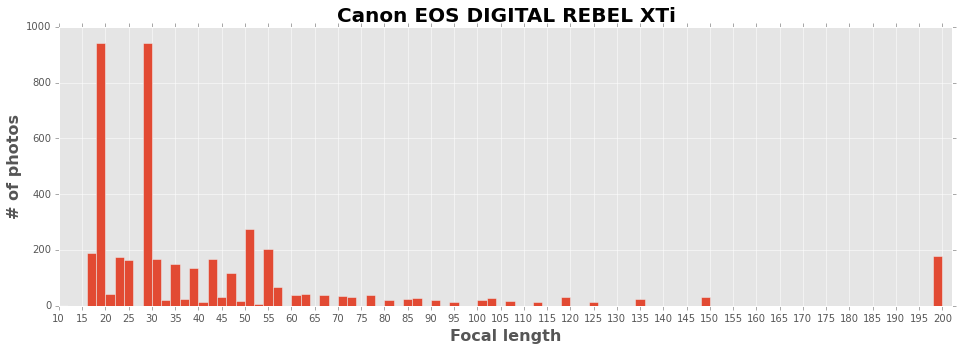

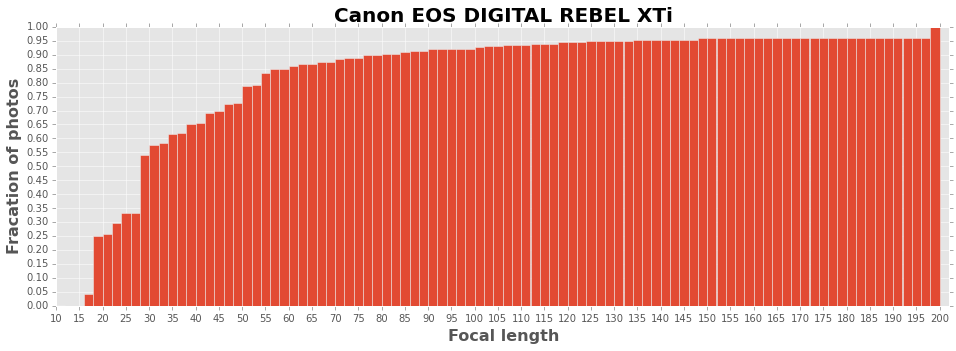

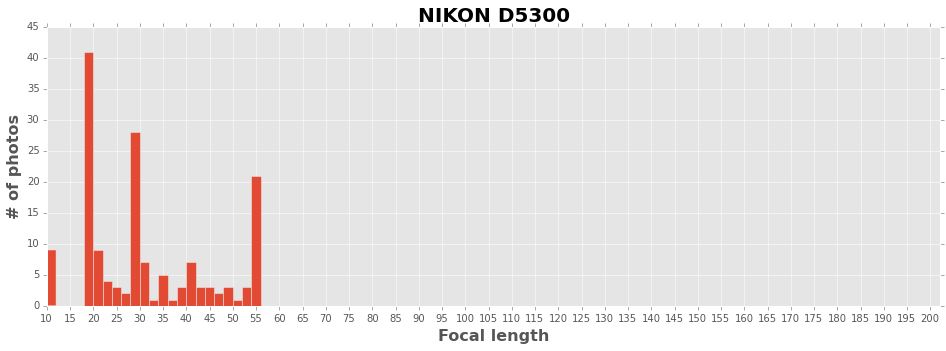

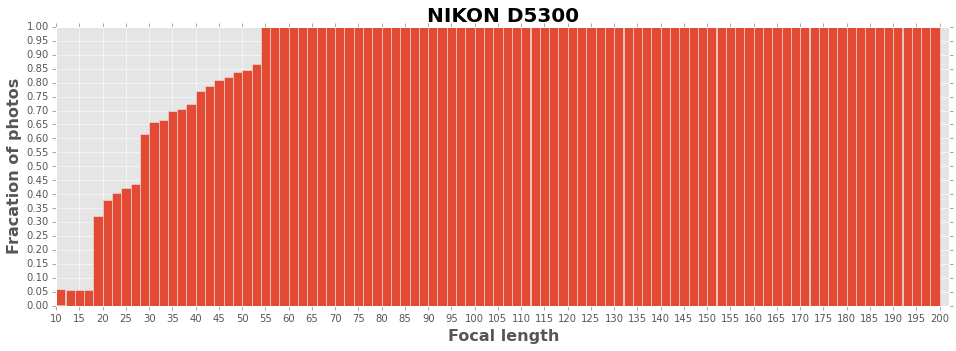

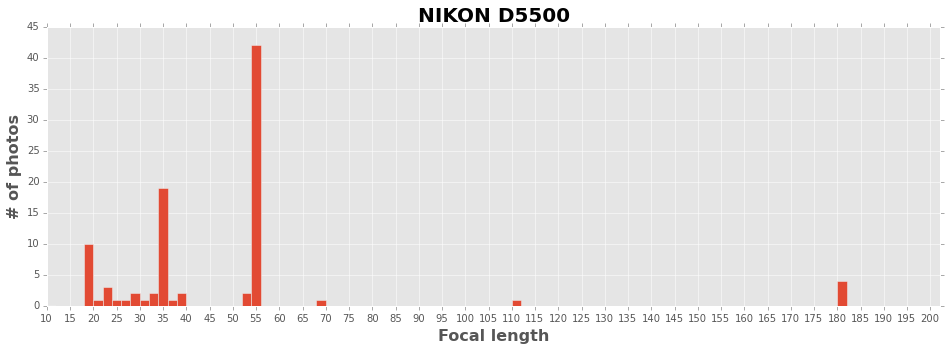

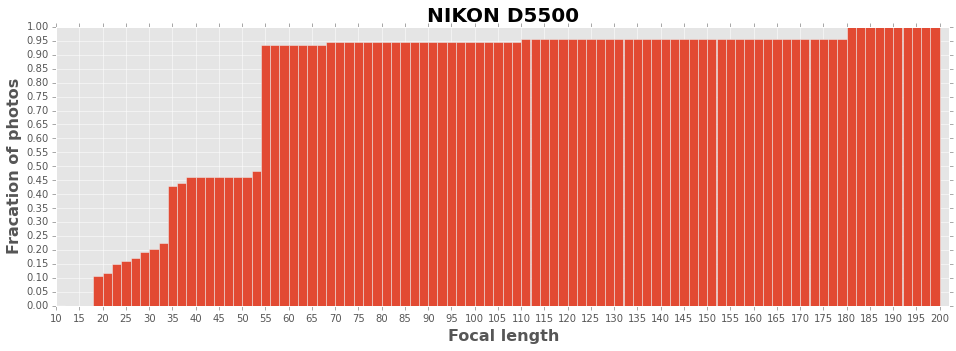

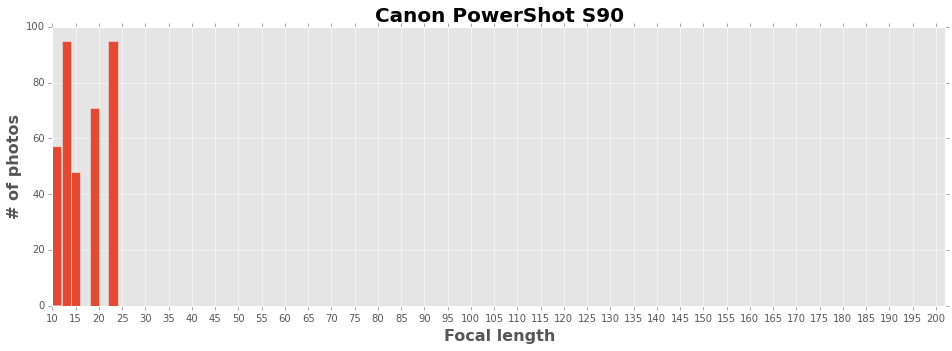

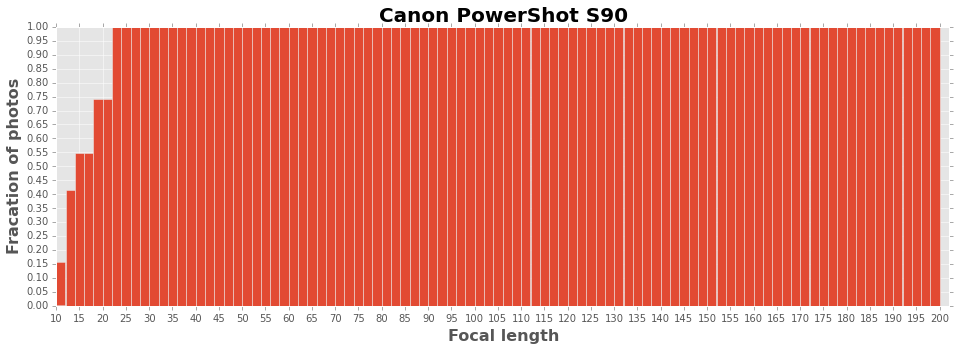

In [14]:
def format_plot(x_range, xticks, yticks, ylabel, xlabel, title):
    """Set names, labels and axis limits on the current matplotlib plot.
    """
    axis_label_props_dict = {'fontsize': 16, 'fontweight': 'bold'}
    title_props_dict = {'fontsize': 20, 'fontweight': 'bold'}
    plt.xlim(x_range)
    plt.gca().set_xticks(xticks);
    if yticks is not None:
        plt.gca().set_yticks(yticks);
    plt.ylabel(ylabel, **axis_label_props_dict)
    plt.xlabel(xlabel, **axis_label_props_dict)
    plt.title(title, **title_props_dict)
    
def plot_for_camera(model):
    """Generate a histrogram and CDF by focal length for the provided model
    of camera.
    """
    plt.figure()
    xti = exif_df.query('Model == "{}"'.format(model))
    xti['RealFocalLength'].hist(bins=xrange(10, 202, 2), figsize=(16, 5))
    format_plot([10, 202], xrange(10, 202, 5), None, 
                '# of photos', 'Focal length', model)
    plt.figure()
    xti['RealFocalLength'].hist(bins=xrange(10, 202, 2), 
                                figsize=(16, 5), 
                                cumulative=True,
                                normed=True)
    format_plot([10, 202], xrange(10, 202, 5), np.arange(0, 1.01, .05), 
                'Fracation of photos', 'Focal length', model)
    plt.ylim([0, 1])
    
camera_models = ['Canon EOS DIGITAL REBEL XTi',
                 'NIKON D5300',
                 'NIKON D5500',
                 'Canon PowerShot S90']
for model in camera_models:
    plot_for_camera(model)

With all this data available, I was also curious how my camera usage as evolved over time. Important life events and vacations really stand out. The code below creates a table containing the count of images from each camera by day.

In [68]:
images_by_date = exif_df.set_index('DateTimeOriginal')
images_by_date = images_by_date.dropna()
images_by_date = pd.crosstab(index=images_by_date.index, 
                             columns=images_by_date['Model'])
images_by_date = images_by_date[np.not_equal(images_by_date.index.values, pd.NaT)]
images_by_date.index = pd.to_datetime(images_by_date.index,
                                      format='%Y:%m:%d %H:%M:%S',
                                      coerce=True)
images_by_date = images_by_date[pd.notnull(images_by_date.index)]
images_by_date.head()

Model,,"C990Z,D490Z",COOLPIX P2,Canon EOS 5D Mark II,Canon EOS DIGITAL REBEL XSi,Canon EOS DIGITAL REBEL XTi,Canon PowerShot A40,Canon PowerShot A490,Canon PowerShot A70,Canon PowerShot S110,...,FinePix Z10fd,KODAK DX4330 DIGITAL CAMERA,KODAK Z740 ZOOM DIGITAL CAMERA,NIKON D5300,NIKON D5500,NIKON D700,NIKON D7000,iPhone 4,iPhone 4S,iPhone 6 Plus
2002-12-31 21:54:57,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2003-03-29 13:28:50,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003-03-29 13:29:01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003-03-29 13:31:36,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003-03-29 13:31:39,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I wrote this helpful method to annotate the plot below.

In [108]:
def annotate(text, xy, xytext):
    """Annotate the current matplotlib axis"""
    plt.gca().annotate(text, xy=xy, xycoords='axes fraction', 
            xytext=xytext, textcoords='axes fraction', size=22,
            ha='center', 
            zorder=20, 
            bbox=dict(boxstyle='round', 
                      fc='white'),
            arrowprops=dict(color='k', width=2));

To graph the images I filtered out cameras with less than 150 total images and resampled the data to a two month frequency.

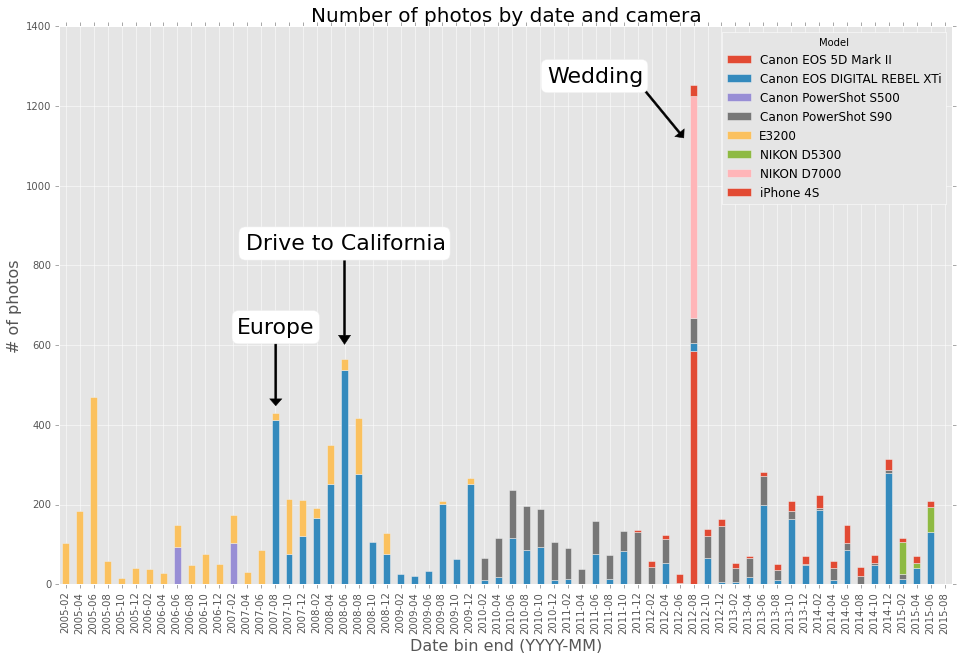

In [140]:
images_by_date = images_by_date.ix[:, (images_by_date.sum() > 150)]
images_by_date = images_by_date.resample('2M', how='sum')
images_by_date['2005':].plot(kind='bar', figsize=(16, 10), stacked=True)
plt.gca().set_xticklabels([tick.get_text()[:7] 
                           for tick in plt.gca().get_xticklabels()])
plt.ylabel('# of photos', fontsize=16)
plt.xlabel('Date bin end (YYYY-MM)', fontsize=16)
plt.title('Number of photos by date and camera', fontsize=20)
annotate('Wedding', (.7, .8), (.6, .9))
annotate('Europe', (.243, .32), (.243, .45))
annotate('Drive to California', (.32, .43), (.32, .6))